# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'prophet'

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [2]:
#sales_df = pd.read_csv('example_retail_sales.csv', index_col='date', parse_dates=True)

df = pd.read_csv('example_retail_sales.csv', parse_dates=True)
sales_df=pd.read_csv('example_retail_sales.csv', parse_dates=True)

In [3]:
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

ds=date
y=sales

Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

<Axes: xlabel='ds'>

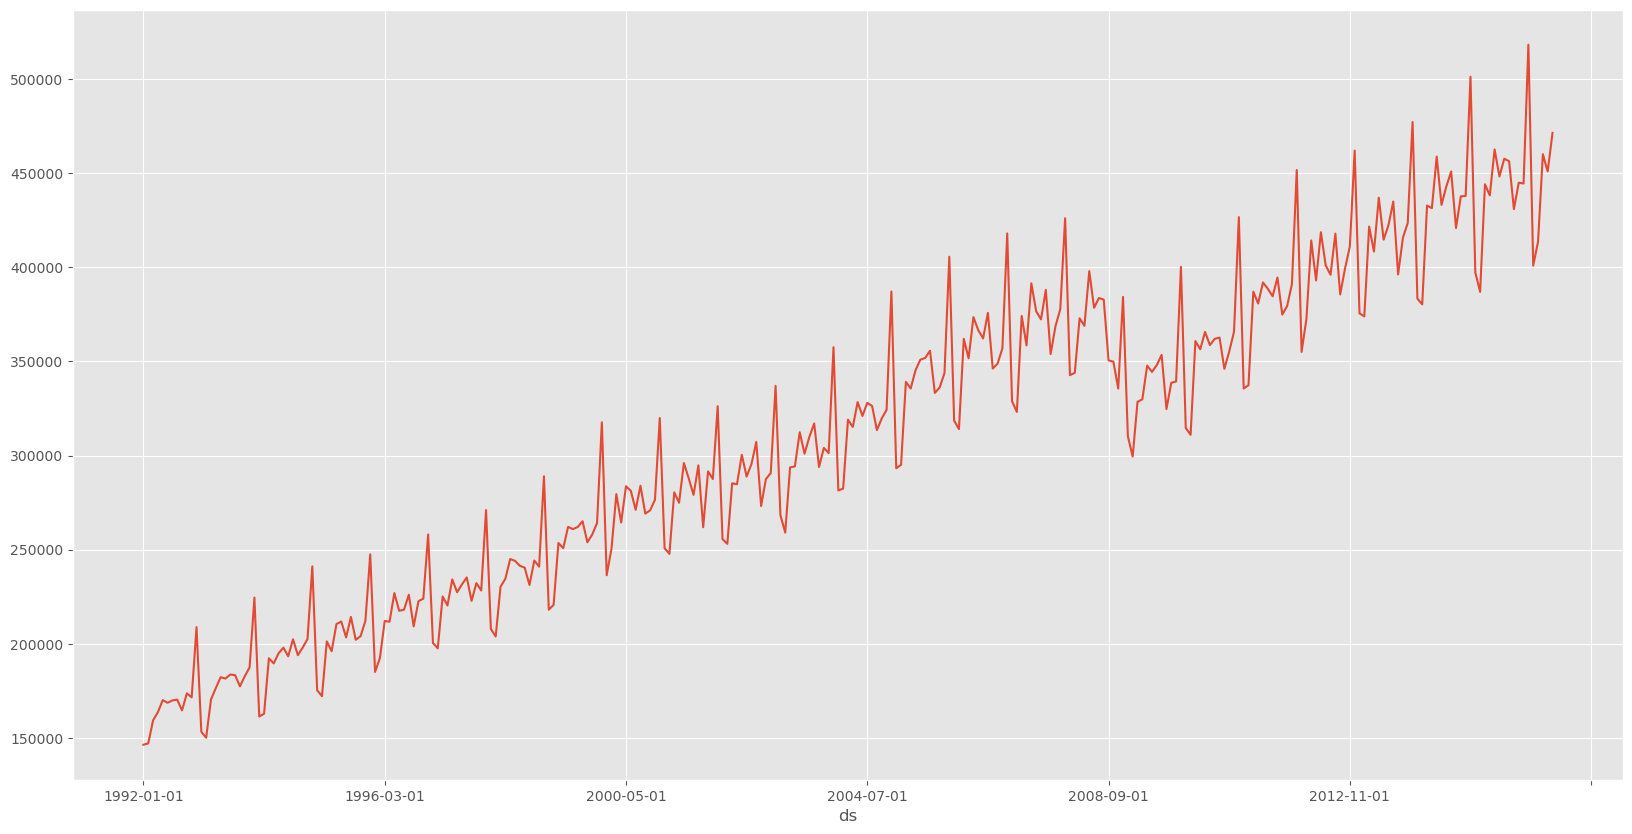

In [4]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In [5]:
df['y'] = np.log(df['y'])

In [6]:
df.tail()

,ds,y
288,2016-01-01,12.901537
289,2016-02-01,12.932543
290,2016-03-01,13.039184
291,2016-04-01,13.019078
292,2016-05-01,13.063507


<Axes: xlabel='ds'>

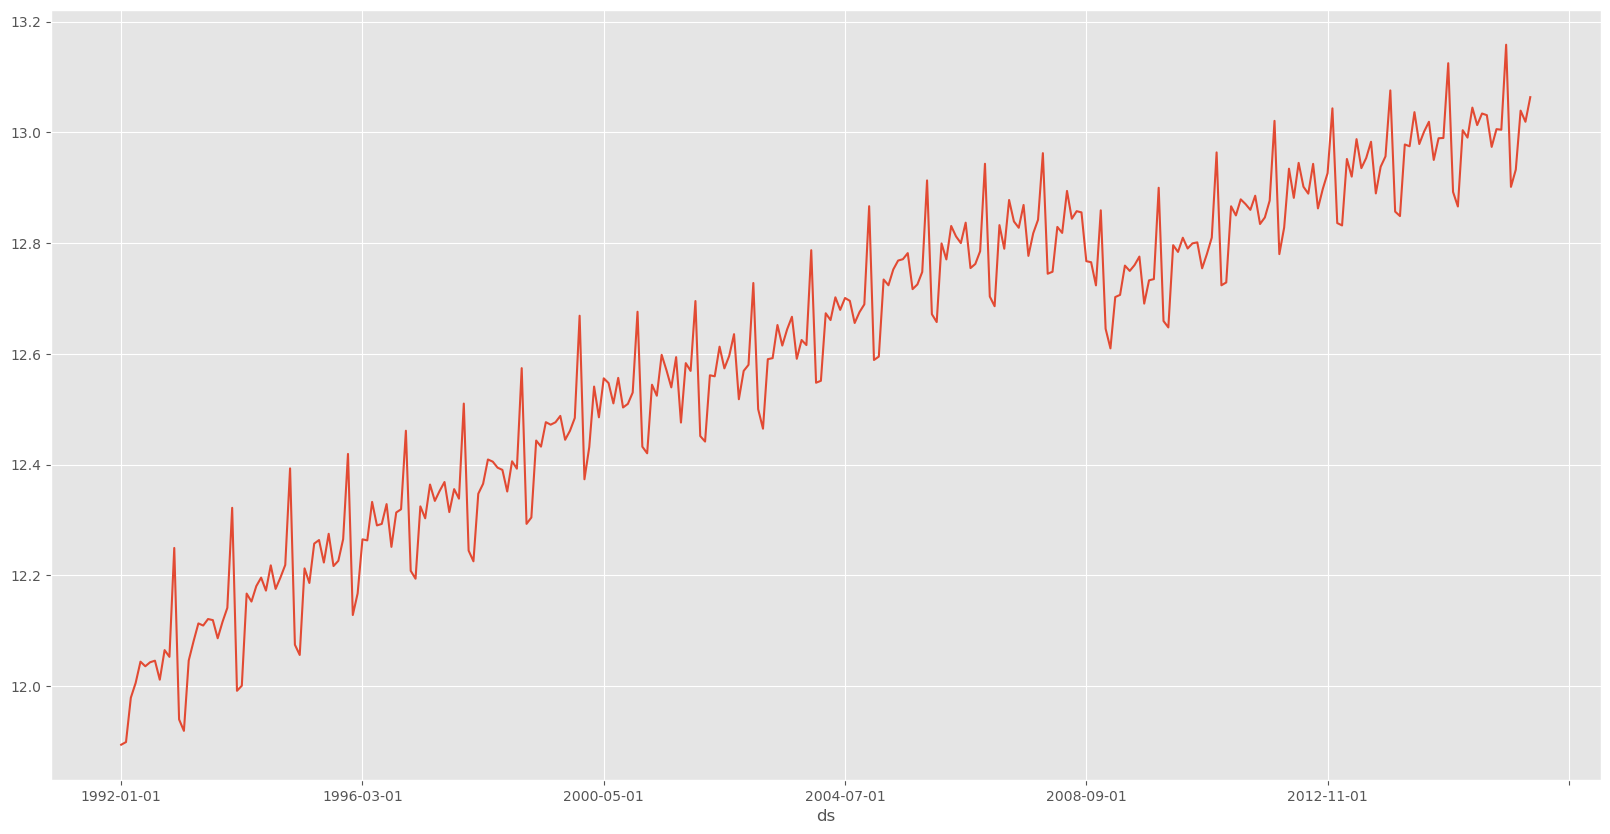

In [7]:
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [8]:
model = Prophet()
model.fit(df);

16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [15]:
future = model.make_future_dataframe(periods=100, freq = 'm')
future.tail()

/home/d321c6c9-7266-478d-aff0-3e1baf06d07f/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds
388,2024-04-30
389,2024-05-31
390,2024-06-30
391,2024-07-31
392,2024-08-31


To forecast this future data, we need to run it through Prophet's model.

In [16]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [17]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
388,2024-04-30,13.321716,12.781300,13.968984,12.745037,13.938540,0.033865,0.033865,0.033865,0.033865,0.033865,0.033865,0.0,0.0,0.0,13.355581
389,2024-05-31,13.324708,12.753594,13.969544,12.733801,13.950902,0.014968,0.014968,0.014968,0.014968,0.014968,0.014968,0.0,0.0,0.0,13.339676
390,2024-06-30,13.327604,12.735465,13.978448,12.726701,13.963641,0.012026,0.012026,0.012026,0.012026,0.012026,0.012026,0.0,0.0,0.0,13.339630
391,2024-07-31,13.330596,12.754694,14.015805,12.715872,13.984271,0.033681,0.033681,0.033681,0.033681,0.033681,0.033681,0.0,0.0,0.0,13.364277
392,2024-08-31,13.333588,12.674305,13.955522,12.711174,14.003349,-0.036120,-0.036120,-0.036120,-0.036120,-0.036120,-0.036120,0.0,0.0,0.0,13.297468


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [18]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
388,2024-04-30,13.355581,12.781300,13.968984
389,2024-05-31,13.339676,12.753594,13.969544
390,2024-06-30,13.339630,12.735465,13.978448
391,2024-07-31,13.364277,12.754694,14.015805
392,2024-08-31,13.297468,12.674305,13.955522


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

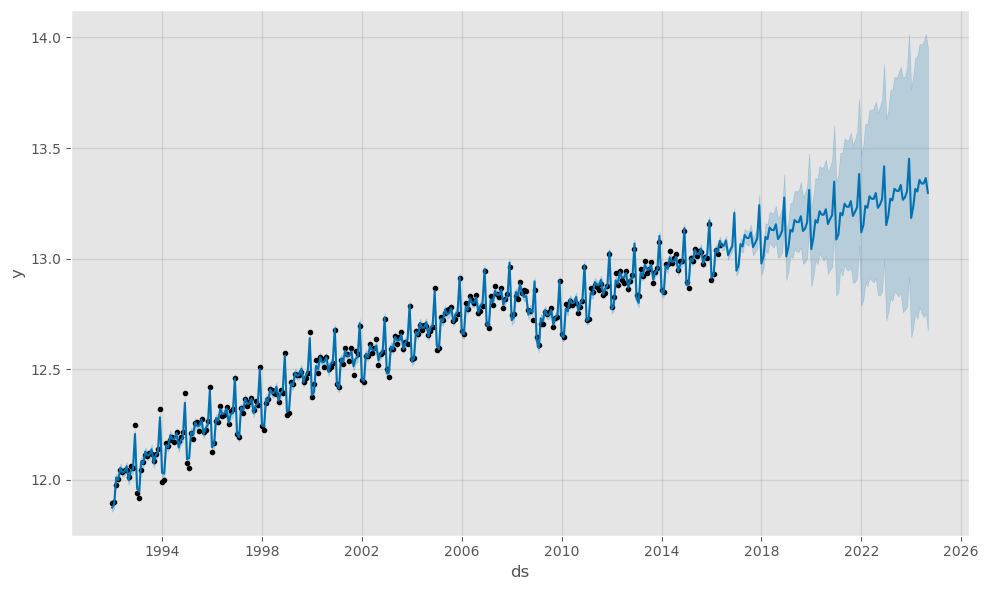

In [19]:
model.plot(forecast);

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 